
# Project Problems:

How to predict the heart failure?

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import time

In [50]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [4]:
path = 'gdrive/MyDrive/DATA/Heart Failure/'

In [5]:
os.listdir(path)

['heart.csv', 'hf_v1.pkl', 'data_interim.csv', 'standardS_hfv1.pkl']

## Get the Data

In [6]:
df = pd.read_csv(path + 'heart.csv')

In [7]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [8]:
df.shape

(918, 12)

In [11]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [10]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Data Preparation
It will consist the simple EDA and Feature Engineering

In [13]:
def plot_compare(mydata, col_target, col_x):
  d1=mydata[mydata[col_target==1]][col_x]
  d2=mydata[mydata[col_target==0]][col_x]
  plt.figure(figsize=(7.5,7.5))
  sns.distplot(d1, label='Heart Disease')
  sns.distplot(d2, label='Not Heart Disease')
  plt.legend(loc='upper left')

### Devide the columns type

In [14]:
df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [15]:
#### predictor 
col_num = ['Age', 'RestingBP', 'Cholesterol','MaxHR','Oldpeak'] ## --> pure number
col_cat = ['Sex', 'ChestPainType', 'FastingBS','RestingECG','ExerciseAngina', 'ST_Slope'] ## --> categorical
other_col = list(set(df.columns)-set(col_num + col_cat)) ## --> others

In [16]:
other_col

['HeartDisease']

In [17]:
col_target = ['HeartDisease']

In [18]:
target_count = df[col_target].value_counts()
target_count/target_count.sum()

HeartDisease
1               0.553377
0               0.446623
dtype: float64

In [20]:
col_cat

['Sex',
 'ChestPainType',
 'FastingBS',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope']

In [29]:
# Check Unique values in categorical columns
for col in col_cat:
  print('{} has {} values '.format(col,df[col].unique()))
  print('\n')

Sex has ['M' 'F'] values 


ChestPainType has ['ATA' 'NAP' 'ASY' 'TA'] values 


FastingBS has [0 1] values 


RestingECG has ['Normal' 'ST' 'LVH'] values 


ExerciseAngina has ['N' 'Y'] values 


ST_Slope has ['Up' 'Flat' 'Down'] values 




In [21]:
df.groupby('Sex').agg({col_target[0]:[np.mean,np.std,np.size]})

HeartDisease               
            mean       std size
Sex                            
F       0.259067  0.439262  193
M       0.631724  0.482670  725

In [22]:
df.groupby('ChestPainType').agg({col_target[0]:[np.mean,np.std,np.size]})

HeartDisease               
                      mean       std size
ChestPainType                            
ASY               0.790323  0.407489  496
ATA               0.138728  0.346666  173
NAP               0.354680  0.479599  203
TA                0.434783  0.501206   46

In [23]:
df.groupby('FastingBS').agg({col_target[0]:[np.mean,np.std,np.size]})

HeartDisease               
                  mean       std size
FastingBS                            
0             0.480114  0.499960  704
1             0.794393  0.405092  214

In [24]:
df.groupby('RestingECG').agg({col_target[0]:[np.mean,np.std,np.size]})

HeartDisease               
                   mean       std size
RestingECG                            
LVH            0.563830  0.497233  188
Normal         0.516304  0.500187  552
ST             0.657303  0.475950  178

In [25]:
df.groupby('ExerciseAngina').agg({col_target[0]:[np.mean,np.std,np.size]})

HeartDisease               
                       mean       std size
ExerciseAngina                            
N                  0.351005  0.477722  547
Y                  0.851752  0.355826  371

In [26]:
df.groupby('ST_Slope').agg({col_target[0]:[np.mean,np.std,np.size]})

HeartDisease               
                 mean       std size
ST_Slope                            
Down         0.777778  0.419079   63
Flat         0.828261  0.377564  460
Up           0.197468  0.398594  395

### Feature Engineering

In [27]:
## Categorical Handling
## One Hot, Dummy, Hashing

onehot = OneHotEncoder()
onehot.fit(df[col_cat])

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [28]:
# [1,2,1,3,2,1] --> [[1,0,0],
                  #  [0,1,0],
                  #  [1,0,0],
                  #  [0,0,1],
                  #  [0,1,0],
                  #  [1,0,0]]

# [1,2,1,3,2,1] --> [[1,0],
                  #  [0,1],
                  #  [1,0],
                  #  [0,0],
                  #  [0,1],
                  #  [1,0]]

In [30]:
col_cat2 = []
for i,j in zip(col_cat, onehot.categories_):
  for e in j:
    col_cat2.append(str(i)+'_'+str(e))

In [31]:
df[col_cat2] = pd.DataFrame(onehot.transform(df[col_cat]).toarray())

In [34]:
df[col_cat2].head()

,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_0,FastingBS_1,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


In [35]:
## Numerical Handling
## Standarized, Caping.. Remember, the real data should have the same standarization or any transformation

SS = StandardScaler()
SS.fit(df[col_num])

col_num2 = [c+'_SS' for c in col_num]
df[col_num2] = pd.DataFrame(SS.transform(df[col_num]))

In [36]:
joblib.dump(SS, path + 'standardS_hfv1.pkl')

['gdrive/MyDrive/DATA/Heart Failure/standardS_hfv1.pkl']

In [37]:
df[col_num2].sample(5)

,Age_SS,RestingBP_SS,Cholesterol_SS,MaxHR_SS,Oldpeak_SS
366,0.794391,0.951331,-1.818435,-0.778472,1.043759
733,1.324756,0.951331,0.248804,-0.896367,1.606617
562,0.582246,0.410909,0.687864,0.675561,1.043759
875,0.476173,-0.669935,1.291571,1.382928,-0.832432
879,-0.584556,-1.210356,0.276246,1.225735,0.105664


In [38]:
col_cat2,col_num2

(['Sex_F',
  'Sex_M',
  'ChestPainType_ASY',
  'ChestPainType_ATA',
  'ChestPainType_NAP',
  'ChestPainType_TA',
  'FastingBS_0',
  'FastingBS_1',
  'RestingECG_LVH',
  'RestingECG_Normal',
  'RestingECG_ST',
  'ExerciseAngina_N',
  'ExerciseAngina_Y',
  'ST_Slope_Down',
  'ST_Slope_Flat',
  'ST_Slope_Up'],
 ['Age_SS', 'RestingBP_SS', 'Cholesterol_SS', 'MaxHR_SS', 'Oldpeak_SS'])

In [40]:
## Then explore it again... if necessery
corr_values = df[col_cat2+col_num2+col_target].corr()[col_target[0]].abs().sort_values()
corr_values

RestingECG_LVH       0.010670
ChestPainType_TA     0.054790
RestingECG_Normal    0.091580
RestingECG_ST        0.102527
RestingBP_SS         0.107589
ST_Slope_Down        0.122527
ChestPainType_NAP    0.212964
Cholesterol_SS       0.232741
FastingBS_0          0.267291
FastingBS_1          0.267291
Age_SS               0.282039
Sex_F                0.305445
Sex_M                0.305445
MaxHR_SS             0.400421
ChestPainType_ATA    0.401924
Oldpeak_SS           0.403951
ExerciseAngina_Y     0.494282
ExerciseAngina_N     0.494282
ChestPainType_ASY    0.516716
ST_Slope_Flat        0.554134
ST_Slope_Up          0.622164
HeartDisease         1.000000
Name: HeartDisease, dtype: float64

In [41]:
corr_values[corr_values>0.12].index.tolist()

['ST_Slope_Down',
 'ChestPainType_NAP',
 'Cholesterol_SS',
 'FastingBS_0',
 'FastingBS_1',
 'Age_SS',
 'Sex_F',
 'Sex_M',
 'MaxHR_SS',
 'ChestPainType_ATA',
 'Oldpeak_SS',
 'ExerciseAngina_Y',
 'ExerciseAngina_N',
 'ChestPainType_ASY',
 'ST_Slope_Flat',
 'ST_Slope_Up',
 'HeartDisease']

In [42]:
## Summarize all the column that will be used 
col_used = corr_values[corr_values>0.12].index.tolist()
col_used.sort()
col_used.remove(col_target[0])

#or
#col_used = col_cat2 + col_num2
col_used

['Age_SS',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'Cholesterol_SS',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'FastingBS_0',
 'FastingBS_1',
 'MaxHR_SS',
 'Oldpeak_SS',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up',
 'Sex_F',
 'Sex_M']

In [43]:
## Prepare the consumable data
X = df[col_used]
Y = df[col_target].values.reshape(len(df))

In [44]:
X.shape

(918, 16)

In [45]:
Y.shape

(918,)

### Train-Test Splitting
80:20 splitting

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=123)

In [48]:
X_train.shape

(734, 16)

In [49]:
X_test.shape

(184, 16)

##Model Training


In [51]:
model_hf = RandomForestClassifier(n_estimators=10, max_depth=15, min_samples_split=3)

In [52]:
model_hf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Model Validation
### Basic Evaluation
This is the basic evaluation for classification problem

In [53]:
def model_validation_metrics(confusion_matrix):
  tn, fp, fn, tp = confusion_matrix.ravel()
  return (tp + tn)/(tp+tn+fp+fn), tp/(tp+fp), tp/(tp+fn)

def roc_curve_func(y_true, y_score):
  # compute fpr, tpr, thresholds and roc_auc
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = roc_auc_score(y_true, y_score)

  # plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  #random prediction curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - specifity)')
  plt.ylabel('True Positive Rate or (specifity')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')

In [54]:
## Benchmark Accuracy of the good model
max(1-df[col_target].mean().values[0], df[col_target].mean().values[0])

0.5533769063180828

In [55]:
## Predict using the trained model and check the confusion matrix
y_train_pred = model_hf.predict(X_train)
y_train_pred_proba = model_hf.predict_proba(X_train)[:,1]

cm_train = confusion_matrix(y_train, y_train_pred)

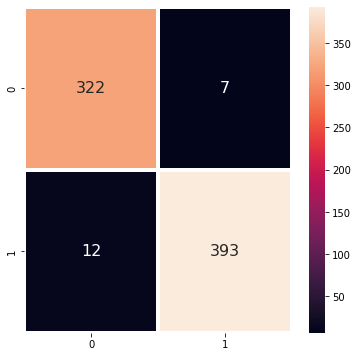

In [56]:
plt.figure(figsize=(6,6))
sns.heatmap(cm_train, annot=True, fmt=',.0f', linewidths=3, annot_kws={'fontsize':16})

In [57]:
accuracy, precision, recall = model_validation_metrics(cm_train)
print(accuracy, precision, recall)

0.9741144414168937 0.9825 0.9703703703703703


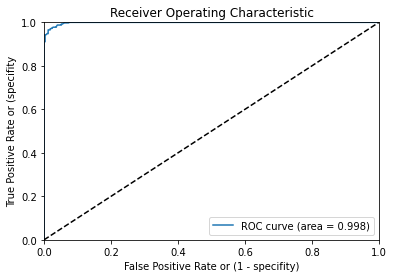

In [58]:
roc_curve_func(y_train, y_train_pred_proba)

## Cross Validation

In [59]:
y_train_pred = model_hf.predict(X_train)
y_test_pred = model_hf.predict(X_test)

In [60]:
cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

In [61]:
def basic_eval(tm,cm):
  plt.figure(figsize=(6,6))
  plt.title(tm+' Evaluation')
  sns.heatmap(cm, annot=True, fmt=',.0f', linewidths=3, annot_kws={'fontsize':16})
  accuracy,precision,recall = model_validation_metrics(cm)
  print('accuracy :',accuracy)
  print('precision :',precision)
  print('recall :',recall)

accuracy : 0.9741144414168937
precision : 0.9825
recall : 0.9703703703703703


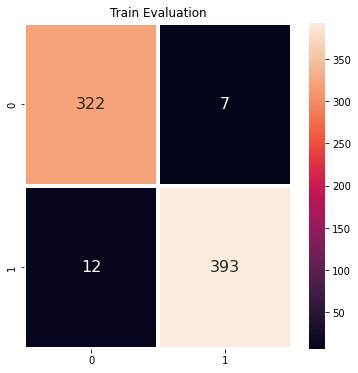

In [62]:
basic_eval('Train', cm_train)

accuracy : 0.8532608695652174
precision : 0.8518518518518519
recall : 0.8932038834951457


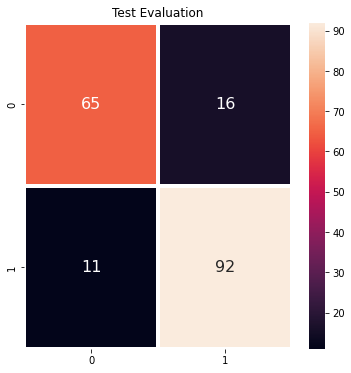

In [63]:
basic_eval('Test', cm_test)

## Bias-variance trade-off

In [64]:
## Check on hyperparameter changing
hyper_param_list= [2,3,4,5,6,7,8,9,10,11,12,13]

In [66]:
df_trade_off = []
for md in hyper_param_list:
  model_hf_trade_off = RandomForestClassifier(n_estimators=10, max_depth=md, min_samples_split=3)

  # model_base = RandomForestClassifier(n_estimators=10, max_depth=md, min_samples_split=3)
  # model_hf_trade_off = AdaBoostClassifier(base_estimator=model_base ,n_estimators=15, learning_rate=0.2, random_state=321)

  model_hf_trade_off.fit(X_train, y_train)
  y_train_pred_temp = model_hf_trade_off.predict(X_train)
  y_test_pred_temp = model_hf_trade_off.predict(X_test)
  cm_train = confusion_matrix(y_train, y_train_pred_temp)
  cm_test = confusion_matrix(y_test, y_test_pred_temp)
  acc_train,p,r = model_validation_metrics(cm_train)
  acc_test,p,r = model_validation_metrics(cm_test)
  df_trade_off.append([acc_train, acc_test])
df_trade_off = pd.DataFrame(df_trade_off,columns=['train_accuracy','test_accuracy'], index=hyper_param_list)

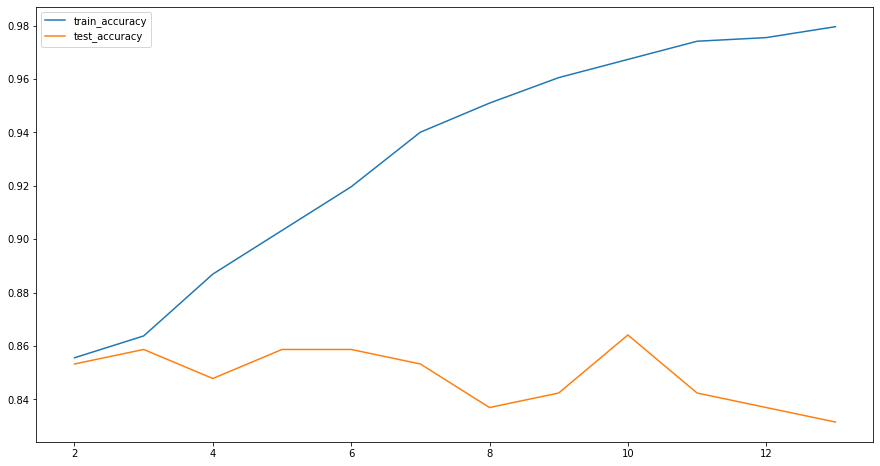

In [67]:
df_trade_off.plot(figsize=(15,8))
plt.show()

## Model selection
Grid Search

In [68]:
parameters = {'n_estimators':[10,20,30,40], 'max_depth':[5,6,7,8,9,10], 'min_samples_split':[3,5,7,9,11], 'max_leaf_nodes':[8,12,16,20]}
model_base = RandomForestClassifier(n_estimators=10, max_depth=md, min_samples_split=3,min_samples_leaf=2, max_leaf_nodes=4)
clf_search1 = GridSearchCV(model_base, parameters, cv=5, verbose=1)

In [71]:
L0 = time.time()
clf_search1.fit(X_train,y_train)
print(time.time() - L0)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


106.52611255645752


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:  1.8min finished


In [72]:
# clf.cv_results_
clf_search1.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=20, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [73]:
clf_search1.best_score_

0.8842139595564253

Random search

In [74]:
parameters = {'n_estimators':[10,20,30,40], 'max_depth':[5,6,7,8,9,10], 'min_samples_split':[3,5,7,9,11], 'max_leaf_nodes':[8,12,16,20]}
model_base = RandomForestClassifier(n_estimators=10, max_depth=md, min_samples_split=3,min_samples_leaf=2, max_leaf_nodes=4)
clf_search2 = RandomizedSearchCV(model_base, param_distributions=parameters, n_iter=60, cv=5, verbose=1)

In [75]:
L0 = time.time()
clf_search2.fit(X_train,y_train)
print(time.time() - L0)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


11.992514371871948


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   11.9s finished


In [76]:
# clf.cv_results_
clf_search2.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=16, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [77]:
clf_search2.best_score_

0.8842139595564253

## Select the model

In [78]:
model_hf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=20, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
model_hf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=20, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [80]:
y_train_pred = model_hf.predict(X_train)
y_test_pred = model_hf.predict(X_test)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

accuracy : 0.8950953678474114
precision : 0.8813953488372093
recall : 0.9358024691358025


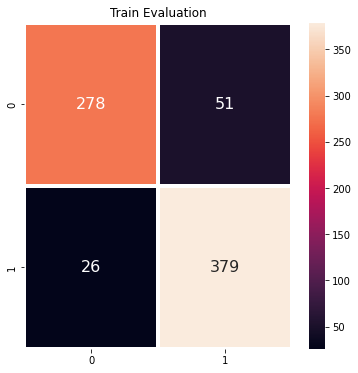

In [81]:
basic_eval('Train', cm_train)

accuracy : 0.8532608695652174
precision : 0.8333333333333334
recall : 0.9223300970873787


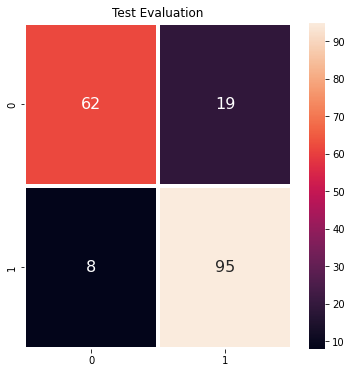

In [82]:
basic_eval('Test', cm_test)

In [83]:
model_hf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=20, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=11,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Best Features

In [84]:
col_used

['Age_SS',
 'ChestPainType_ASY',
 'ChestPainType_ATA',
 'ChestPainType_NAP',
 'Cholesterol_SS',
 'ExerciseAngina_N',
 'ExerciseAngina_Y',
 'FastingBS_0',
 'FastingBS_1',
 'MaxHR_SS',
 'Oldpeak_SS',
 'ST_Slope_Down',
 'ST_Slope_Flat',
 'ST_Slope_Up',
 'Sex_F',
 'Sex_M']

In [85]:

model_hf.feature_importances_

array([0.034375  , 0.12072173, 0.01878678, 0.00686828, 0.05836448,
       0.05073022, 0.0494848 , 0.01817228, 0.01476113, 0.04878354,
       0.05662494, 0.00590169, 0.07900267, 0.37185316, 0.05026042,
       0.01530889])

In [86]:
df_imp = pd.DataFrame({'cols':col_used, 'importance':model_hf.feature_importances_})
df_imp = df_imp.set_index('cols')

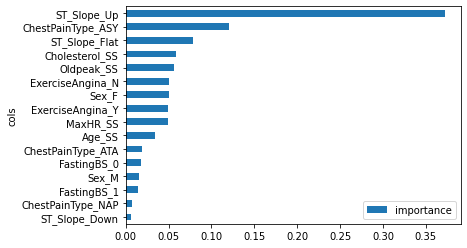

In [87]:
df_imp.sort_values('importance').plot(kind='barh')

## Save and Load model


In [88]:
joblib.dump(model_hf, path + 'hf_v1.pkl')

['gdrive/MyDrive/DATA/Heart Failure/hf_v1.pkl']

In [89]:
model_hf_load = joblib.load(path + 'hf_v1.pkl')
model_standard_scaler = joblib.load(path + 'standardS_hfv1.pkl')

In [94]:
unit_data = X_test.sample()
model_hf_load.predict(unit_data)

array([0])

In [95]:
unit_data

,Age_SS,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,Cholesterol_SS,ExerciseAngina_N,ExerciseAngina_Y,FastingBS_0,FastingBS_1,MaxHR_SS,Oldpeak_SS,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,Sex_F,Sex_M
170,-2.599942,0.0,1.0,0.0,0.404305,1.0,0.0,1.0,0.0,0.91135,-0.832432,0.0,0.0,1.0,0.0,1.0
